In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, ClassifierMixin 
import seaborn as sb

# Comparison of Regressors for Abalone Age Prediction
In this assignment, the objective is to compare the performance of different regressors on the Abalone dataset. What is the best algorithm for the dataset?

In [263]:
abalone_data = pd.read_csv('data/abalone.data')
abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Describe the dataset:
This dataset is supposed to predict the age of an abalone. The features contain information about the abalones gender and size.
the target tells how many rings the target has, which is used to determine the age in years.  
  
the uci link tells us that the missing values were removed from the dataset, and that the ranges of the continuous vales have been scaled.  
https://archive.ics.uci.edu/dataset/1/abalone

# encoding the categorical feature
this will make it easier to use the explorary functions

In [264]:
label_encoder = LabelEncoder()

abalone_data['M'] = label_encoder.fit_transform(abalone_data['M'])

abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Exploratory analysis of the dataset
looking at the distribution of the features it looks like most of them are normally distributed, besides the column M for gender.  
this means that the best models for this dataset would be DecisionTreeRegressor, a linearregressor and SVR

array([[<Axes: title={'center': 'M'}>, <Axes: title={'center': '0.455'}>,
        <Axes: title={'center': '0.365'}>],
       [<Axes: title={'center': '0.095'}>,
        <Axes: title={'center': '0.514'}>,
        <Axes: title={'center': '0.2245'}>],
       [<Axes: title={'center': '0.101'}>,
        <Axes: title={'center': '0.15'}>, <Axes: title={'center': '15'}>]],
      dtype=object)

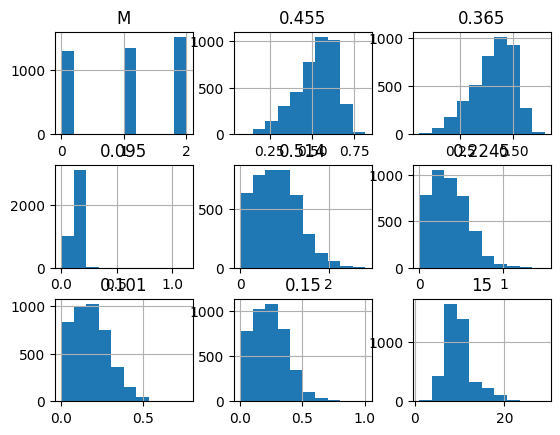

In [265]:
abalone_data.hist()

# Correlation
it looks like the features of the dataset are heavily correlated, beside the M feature and the target. 

In [266]:
abalone_corr = abalone_data.corr()
abalone_corr.style.background_gradient(cmap='coolwarm')

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
M,1.000000,-0.035915,-0.038762,-0.041796,-0.021219,-0.001205,-0.031873,-0.034686,-0.035076
0.455,-0.035915,1.000000,0.986813,0.827552,0.925255,0.897905,0.903010,0.897697,0.557123
0.365,-0.038762,0.986813,1.000000,0.833705,0.925452,0.893159,0.899726,0.905328,0.575005
0.095,-0.041796,0.827552,0.833705,1.000000,0.819209,0.774957,0.798293,0.817326,0.558109
0.514,-0.021219,0.925255,0.925452,0.819209,1.000000,0.969403,0.966372,0.955351,0.540818
0.2245,-0.001205,0.897905,0.893159,0.774957,0.969403,1.000000,0.931956,0.882606,0.421256
0.101,-0.031873,0.903010,0.899726,0.798293,0.966372,0.931956,1.000000,0.907647,0.504274
0.15,-0.034686,0.897697,0.905328,0.817326,0.955351,0.882606,0.907647,1.000000,0.628031
15,-0.035076,0.557123,0.575005,0.558109,0.540818,0.421256,0.504274,0.628031,1.000000


# Necessary pre-processing of data

# PCA
we can take all of the correlated features 0.45, 0.365, 0.095, 0.514, 0.2245, 0.101 and 0.15
and reduce their dimentionality, this could make it easier for the model to see patterns and undertsnad the information when there is no need for this many features.

seeing how much cumulative variance is retained whith every number of pca. a dimention reduction to 2 will give us a lot of information still.

[0.97409888 0.98551837 0.99389476 0.99693366 0.99834385 0.99957334
 1.        ]


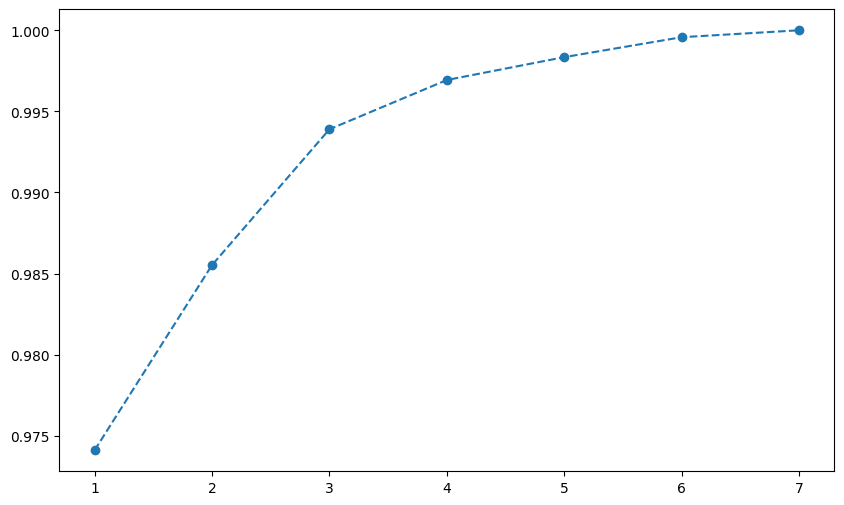

In [267]:
pca = PCA()
number_of_pca = pca.fit_transform(abalone_data.iloc[:, 1:8])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

In [268]:
pca = ColumnTransformer([
     ("pca", PCA(2), slice(1, 8))])

# pipe to easily access the changes in the data

In [ ]:
def pipe_altered_data(model):
    return Pipeline([('pca', pca), ('classifier', model)])

# Split the dataset
i chose a 80% train_val set and 20% testing set. This will ensure that i have enough data for grid search and again split the data into train and validation. I will also have enough data at the end for testing with 20% test data

In [270]:
features = abalone_data.drop('15', axis=1)
targets = abalone_data['15']

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

# hyperparameter tuning to find the best possible classifiers
i will be using nested cross validation for each algortihm that i am going to test, to make sure that i got the best combination of parameters. to evaluate during the tuning process i will be looking at r2, absolute error, and mean squared error.

i will be first trying singular models, an ensembeled model and a combination to see if a combination of models can give me a better result. 

i wil also be testing on the untuched data to see if the preprocessing made the data better better or not.

i will do the training process over two rounds, so i can test five models with few parameters. then i will test the two best models from round one again with more parameters, to make sure i got the best model. This dataset has a lot more data, so it will be more effective to test more models at the beginning with fewer parameters, then go in depth with the best ones.

# 

# function to evaluate a model
this will return the results of the model, and be used in the function below
  
what we need to look for when evaluating this model:  
This model is going to evaluate the age of an abalone, we should have the highest r^2 and the least big mistakes, so the lowest mean MSE

In [272]:

def evaluate(estimator, X, y):
    predictions = estimator.predict(X)
    return {
        'r2': r2_score(y, predictions), 
        'mean_absolute_error': mean_absolute_error(y, predictions), 
        'mean_squared_error': mean_squared_error(y, predictions)
    }

# function for nested cross validation
# Nested grid search model
This is the best way to find the best model. 
this gridsearch will run an outer loop five times with different parts of the train-val data, then split this data again in the inner loop(four times) which is going to do the grid search. The grid search will then split the part of the data it got into train and validate, and return the best model
  
this method will return a list of five models, for each grid search the best model will be added to this list. it will return the cv_results which contains all the information of each loop of the grid search. The method also return the scores, same as the evaluate function
the models will be returned by the best r2, neg_mean_absolute_error ,  neg_mean_squared_error and refitted so the best r2 is returned

In [273]:
def find_best_models(model, dt_params):
    metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'r2': [],
        'mean_absolute_error': [],
        'mean_squared_error': []
    }

    for (train_index, test_index) in list(outer_cv.split(train_val_features, train_val_targets)):

        dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='r2',return_train_score=True)
        dt_grid.fit(train_val_features.iloc[train_index], train_val_targets.iloc[train_index])

        cv_results = pd.DataFrame(dt_grid.cv_results_)
        dt_cv_results.append(cv_results)
        dt_estimators.append(dt_grid.best_estimator_)

        evaluation = evaluate(dt_grid, train_val_features.iloc[test_index], train_val_targets.iloc[test_index])
        dt_test_scores['r2'].append(evaluation['r2'])
        dt_test_scores['mean_absolute_error'].append(evaluation['mean_absolute_error'])
        dt_test_scores['mean_squared_error'].append(evaluation['mean_squared_error'])
    return dt_estimators, dt_cv_results, dt_test_scores



# first round of parameter tuning models
for the first round of testing models i will be trying a smaller range of paramtes, so i can try many models without getting a too large runtime

# singular models
i will first test singular models

# decision tree regressor with original dataset

In [274]:
dr_params = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
    'max_depth': range(4,8)
}
best_models_dr, cv_results, model_scores = find_best_models(DecisionTreeRegressor(), dr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is DecisionTreeRegressor(criterion='poisson', max_depth=5), because these parameters at the most occuring

In [275]:
print(best_models_dr)

[DecisionTreeRegressor(criterion='poisson', max_depth=6), DecisionTreeRegressor(criterion='poisson', max_depth=4), DecisionTreeRegressor(criterion='friedman_mse', max_depth=5), DecisionTreeRegressor(criterion='poisson', max_depth=5), DecisionTreeRegressor(criterion='poisson', max_depth=6)]


# decision tree regressor with altered dataset

In [382]:
dr_params = {
    'classifier__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
    'classifier__max_depth': range(4,8)
}
best_models_dr, cv_results, model_scores = find_best_models(pipe_altered_data(DecisionTreeRegressor()), dr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is DecisionTreeRegressor(criterion='poisson', max_depth=4)

In [383]:
print(best_models_dr)

[Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier',
                 DecisionTreeRegressor(criterion='poisson', max_depth=4))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier',
                 DecisionTreeRegressor(criterion='poisson', max_depth=4))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier',
                 DecisionTreeRegressor(criterion='poisson', max_depth=4))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                

# linear regressor with normal dataset


In [278]:
lr_params = {
    'alpha': [0.001, 0.01, 0.1, 1], 
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
best_models_lr, cv_results, model_scores = find_best_models(ElasticNet(), lr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is ElasticNet(alpha=0.001, l1_ratio=0.9) every time

In [279]:
print(best_models_lr)

[ElasticNet(alpha=0.001, l1_ratio=0.9), ElasticNet(alpha=0.001, l1_ratio=0.9), ElasticNet(alpha=0.001, l1_ratio=0.9), ElasticNet(alpha=0.001, l1_ratio=0.9), ElasticNet(alpha=0.001, l1_ratio=0.9)]


# linear regressor with altered dataset

In [384]:
lr_params = {
    'classifier__alpha': [0.001, 0.01, 0.1, 1], 
    'classifier__l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
best_models_lr, cv_results, model_scores = find_best_models(pipe_altered_data(ElasticNet()), lr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is ElasticNet(alpha=0.01, l1_ratio=0.1)

In [281]:
print(best_models_lr)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=0.9))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.01, l1_ratio=0.1))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=0.1))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=

# SVR model with original dataset

In [385]:
svr_params = {
    'kernel': ['linear', 'poly', 'rbf'], 
    'degree': [1,3,5,]
}
best_models_svr, cv_results, model_scores = find_best_models(SVR(), svr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is SVR(degree=1)

In [283]:
print(best_models_svr)

[SVR(degree=1), SVR(degree=1), SVR(degree=1), SVR(degree=1), SVR(degree=1)]


# SVR with altered dataset

In [284]:
svr_params = {
    'classifier__kernel': ['linear', 'poly', 'rbf'], 
    'classifier__degree': [1,3,5,]
}
best_models_svr, cv_results, model_scores = find_best_models(pipe_altered_data(SVR()), svr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is SVR(degree=1)

In [285]:
print(best_models_svr)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', SVR(degree=1))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', SVR(degree=1))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', SVR(degree=1))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                         

# evaluation from the first round with singular models:

In [393]:
print("decision tree regressor with original data: ")
decision_tree_best = DecisionTreeRegressor(criterion='poisson', max_depth=5).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_best, test_features, test_targets))
print("decision tree regressor with altered data: ")
decision_tree_pipe_best = pipe_altered_data(DecisionTreeRegressor(criterion='poisson', max_depth=4)).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_pipe_best, test_features, test_targets))

print()

print("Linear regressor elasticNet with original data: ")
elasticnet_best = ElasticNet(alpha=0.001, l1_ratio=0.9).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_best, test_features, test_targets))
print("Linear regressor elasticNet with altered data: ")
elasticnet_pipe_best = pipe_altered_data(ElasticNet(alpha=0.01, l1_ratio=0.1)).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_pipe_best, test_features, test_targets))

print()

print("SVR model with original data: ")
svr_best = SVR(degree=1).fit(train_val_features, train_val_targets)
print(evaluate(svr_best, test_features, test_targets))
print("SVR model with altered data: ")
svr_pipe_best = pipe_altered_data(SVR(degree=1)).fit(train_val_features, train_val_targets)
print(evaluate(svr_pipe_best, test_features, test_targets))


decision tree regressor with original data: 
{'r2': 0.49403824461408663, 'mean_absolute_error': 1.6354428600380484, 'mean_squared_error': 5.58529013991784}
decision tree regressor with altered data: 
{'r2': 0.4479491516944468, 'mean_absolute_error': 1.771306175262166, 'mean_squared_error': 6.094065661983688}

Linear regressor elasticNet with original data: 
{'r2': 0.4992896753864019, 'mean_absolute_error': 1.670381815877722, 'mean_squared_error': 5.527319820618305}
Linear regressor elasticNet with altered data: 
{'r2': 0.39545872774029056, 'mean_absolute_error': 1.8578619761057522, 'mean_squared_error': 6.67350520307636}

SVR model with original data: 
{'r2': 0.4688137638448817, 'mean_absolute_error': 1.5950638307688485, 'mean_squared_error': 5.863742102393401}
SVR model with altered data: 
{'r2': 0.46461891025139246, 'mean_absolute_error': 1.6199136053115193, 'mean_squared_error': 5.910048911484621}


# ensambeled method

# random forest regressor with original data

In [388]:
rfr_params = {
    'n_estimators': [80, 90, 100]
}
best_models_rfr, cv_results, model_scores = find_best_models(RandomForestRegressor(), rfr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is RandomForestRegressor(n_estimators=90), two are 90 and two are 80, but the fifth one is 100 so i would say the best number of estimators is 90

In [390]:
print(best_models_rfr)

[RandomForestRegressor(n_estimators=90), RandomForestRegressor(n_estimators=90), RandomForestRegressor(), RandomForestRegressor(n_estimators=80), RandomForestRegressor(n_estimators=80)]


# random forest regressor with altered data

In [289]:
rfr_params = {
    'classifier__n_estimators': [80, 90, 100]
}
best_models_rfr, cv_results, model_scores = find_best_models(pipe_altered_data(RandomForestRegressor()), rfr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

the best model is RandomForestRegressor(n_estimators=80)

In [290]:
print(best_models_rfr)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', RandomForestRegressor(n_estimators=80))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', RandomForestRegressor(n_estimators=90))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', RandomForestRegressor(n_estimators=80))]), Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(transform

# first round ensembeled random forest regressor results

In [392]:
print("random forest regressor with original data: ")
random_forest_best = RandomForestRegressor(n_estimators=90).fit(train_val_features, train_val_targets)
print(evaluate(random_forest_best, test_features, test_targets))
print("random forest regressor with altered data: ")
random_forest_pipe_best = pipe_altered_data(RandomForestRegressor(n_estimators=80)).fit(train_val_features, train_val_targets)
print(evaluate(random_forest_pipe_best, test_features, test_targets))

random forest regressor with original data: 
{'r2': 0.5319918565224848, 'mean_absolute_error': 1.5987639553429027, 'mean_squared_error': 5.166321844172721}
random forest regressor with altered data: 
{'r2': 0.4279563922060202, 'mean_absolute_error': 1.8042165071770335, 'mean_squared_error': 6.314764877392344}


# combined method
i will combine the two best singel models to see if i can get even better results
which were SVR model and decisiontree regressor, both with altered data

# method to combine two models
i wanted to try a combined model two, i tested with decision tree regressor and svr, since they gave good results. i will try on the original dataset since this will be harder to try with the pipe

In [292]:
class Combined(ClassifierMixin, BaseEstimator):

    def __init__(self, model_1=SVR(), model1_features=None, model_2=DecisionTreeRegressor(), model_2_features=None):
        self.model1_features = model1_features
        self.model_2_features = model_2_features
        self.model_1 = model_1
        self.model_2 = model_2


    def fit(self, X, y):
        self.model_1.fit(X[self.model1_features], y)
        self.model_2.fit(X[self.model_2_features], y)
       
    def predict(self, X):
        pred1 = self.model_1.predict(X[self.model1_features])
        pred2 = self.model_2.predict(X[self.model_2_features])
        
        combined_pred = (pred1 + pred2) / 2
        return combined_pred


dividing columns for the different models  
there is no spesific way to split the columns, so i just gave half not deicsion tree and the other half to svr

In [398]:
decision_features = ['M', '0.455', '0.365', '0.095']

svr_features = list(filter(lambda x: x not in decision_features, train_val_features.columns))

combined_params = {
        'model_1__degree': [1, 2, 4],
        'model_2__max_depth': range(1,5)
    }

decision_model = DecisionTreeRegressor()
svr_model = SVR()
combined = Combined(model1_features= svr_features, model_2_features=decision_features, model_1=svr_model, model_2=decision_model)
combined

Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_2_features=['M', '0.455', '0.365', '0.095'])

In [399]:
best_models_rfr, cv_results, model_scores = find_best_models(combined, combined_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 371, i

the best models: SVR(degree=1) and model_2=DecisionTreeRegressor(max_depth=1)

In [402]:
print(best_models_rfr)

[Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095']), Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095']), Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095']), Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095']), Combined(model1_features=['0.514', '0.2245', '0.101', '0.15'],
         model_1=SVR(degree=1), model_2=DecisionTreeRegressor(max_depth=1),
         model_2_features=['M', '0.455', '0.365', '0.095'])]

# first round evaluation on the combined model

In [403]:

decision_model = DecisionTreeRegressor(max_depth=1)
svr_model = SVR(degree=1)

combined = Combined(model1_features=svr_features, model_2_features=decision_features, model_1=svr_model, model_2=decision_model)

combined.fit(train_val_features, train_val_targets)

print("Combined model with original data:")
evaluation_result = evaluate(combined, test_features, test_targets)
print(evaluation_result)


Combined model with original data:
{'r2': 0.43120451019554173, 'mean_absolute_error': 1.7320639271932985, 'mean_squared_error': 6.2789090420707065}


# all results from the first evaluation:

In [404]:
print("decision tree regressor with original data: ")
decision_tree_best = DecisionTreeRegressor(criterion='poisson', max_depth=5).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_best, test_features, test_targets))
print("decision tree regressor with altered data: ")
decision_tree_pipe_best = pipe_altered_data(DecisionTreeRegressor(criterion='poisson', max_depth=4)).fit(train_val_features, train_val_targets)
print(evaluate(decision_tree_pipe_best, test_features, test_targets))

print()

print("Linear regressor elasticNet with original data: ")
elasticnet_best = ElasticNet(alpha=0.001, l1_ratio=0.9).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_best, test_features, test_targets))
print("Linear regressor elasticNet with altered data: ")
elasticnet_pipe_best = pipe_altered_data(ElasticNet(alpha=0.01, l1_ratio=0.1)).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_pipe_best, test_features, test_targets))

print()

print("SVR model with original data: ")
svr_best = SVR(degree=1).fit(train_val_features, train_val_targets)
print(evaluate(svr_best, test_features, test_targets))
print("SVR model with altered data: ")
svr_pipe_best = pipe_altered_data(SVR(degree=1)).fit(train_val_features, train_val_targets)
print(evaluate(svr_pipe_best, test_features, test_targets))
print()

print("random forest regressor with original data: ")
random_forest_best = RandomForestRegressor(n_estimators=90).fit(train_val_features, train_val_targets)
print(evaluate(random_forest_best, test_features, test_targets))
print("random forest regressor with altered data: ")
random_forest_pipe_best = pipe_altered_data(RandomForestRegressor(n_estimators=80)).fit(train_val_features, train_val_targets)
print(evaluate(random_forest_pipe_best, test_features, test_targets))

print()
print("Combined model with original data:")
evaluation_result = evaluate(combined, test_features, test_targets)
print(evaluation_result)


decision tree regressor with original data: 
{'r2': 0.49403824461408663, 'mean_absolute_error': 1.6354428600380484, 'mean_squared_error': 5.58529013991784}
decision tree regressor with altered data: 
{'r2': 0.4479491516944468, 'mean_absolute_error': 1.771306175262166, 'mean_squared_error': 6.094065661983688}

Linear regressor elasticNet with original data: 
{'r2': 0.4992896753864019, 'mean_absolute_error': 1.670381815877722, 'mean_squared_error': 5.527319820618305}
Linear regressor elasticNet with altered data: 
{'r2': 0.39545872774029056, 'mean_absolute_error': 1.8578619761057522, 'mean_squared_error': 6.67350520307636}

SVR model with original data: 
{'r2': 0.4688137638448817, 'mean_absolute_error': 1.5950638307688485, 'mean_squared_error': 5.863742102393401}
SVR model with altered data: 
{'r2': 0.46461891025139246, 'mean_absolute_error': 1.6199136053115193, 'mean_squared_error': 5.910048911484621}

random forest regressor with original data: 
{'r2': 0.5272452164700954, 'mean_absolut

# second round of parameter tuning the best models
The two best models from round one were: 
random forest regressor with original data and Linear regressor elasticNet with original data. these have the highest r2 and some of the best mse


# random forest regressor with original data
i could not test with that many parameters as run time got way too high 

In [445]:
rfr_params = {
    'n_estimators': [100, 110, 120],
    'max_depth': [7, 10, 15, 20],
    'min_samples_split': [15, 20, 25]
}
best_models_rfr, cv_results_final_rfr, model_scores = find_best_models(RandomForestRegressor(), rfr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

In [446]:
print(cv_results_final_rfr)

[    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.546656      0.024377         0.010350        0.003689   
1        0.585413      0.001142         0.010329        0.003615   
2        0.633982      0.008444         0.012682        0.003923   
3        0.532744      0.023524         0.010062        0.003728   
4        0.571437      0.018732         0.008769        0.000694   
5        0.624594      0.015352         0.012606        0.003748   
6        0.572076      0.004919         0.010380        0.003501   
7        0.604162      0.036395         0.008358        0.000135   
8        0.627965      0.015898         0.012795        0.004091   
9        0.661917      0.008179         0.014343        0.003602   
10       0.753191      0.025330         0.016699        0.000144   
11       0.794812      0.005583         0.014384        0.003637   
12       0.632671      0.010282         0.012524        0.004300   
13       0.689157      0.006918         0.01026

the results were a bit mixed here too, but i think the most reacurring is: RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=110)

In [447]:
print(best_models_rfr)

[RandomForestRegressor(max_depth=10, min_samples_split=25, n_estimators=110), RandomForestRegressor(max_depth=20, min_samples_split=25, n_estimators=110), RandomForestRegressor(max_depth=10, min_samples_split=15), RandomForestRegressor(max_depth=20, min_samples_split=20, n_estimators=110), RandomForestRegressor(max_depth=10, min_samples_split=25, n_estimators=120)]


from the parameters i have chosen we can see a clear peek from the range, or just a stable line

C:\Users\Kosov\AppData\Local\Temp\ipykernel_27944\2994999660.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sb.lineplot(data=cv_results_rfr, x='param_n_estimators', y='mean_test_r2', estimator='mean', ci='sd')
C:\Users\Kosov\AppData\Local\Temp\ipykernel_27944\2994999660.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sb.lineplot(data=cv_results_rfr, x='param_max_depth', y='mean_test_r2', estimator='mean', ci='sd')
C:\Users\Kosov\AppData\Local\Temp\ipykernel_27944\2994999660.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sb.lineplot(data=cv_results_rfr, x='param_min_samples_split', y='mean_test_r2', estimator='mean', ci='sd')


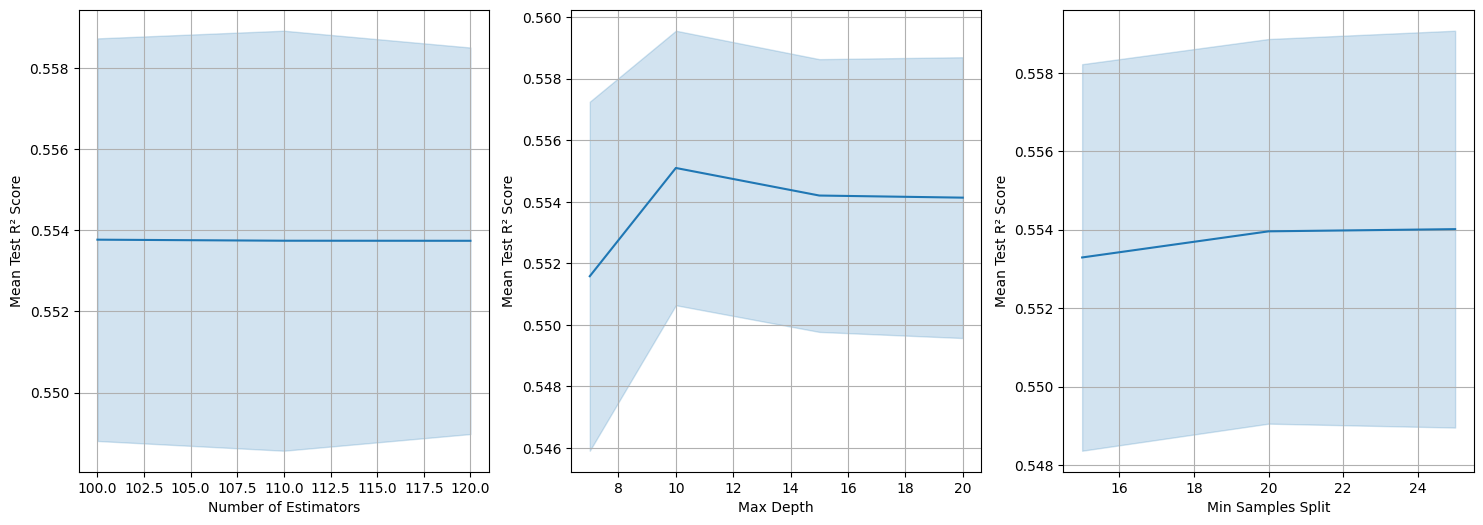

In [448]:
cv_results_rfr = pd.concat(cv_results_final_rfr, ignore_index=True)
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sb.lineplot(data=cv_results_rfr, x='param_n_estimators', y='mean_test_r2', estimator='mean', ci='sd')
plt.xlabel('Number of Estimators')  
plt.ylabel('Mean Test R² Score') 
plt.grid()


plt.subplot(1, 3, 2)
sb.lineplot(data=cv_results_rfr, x='param_max_depth', y='mean_test_r2', estimator='mean', ci='sd')
plt.xlabel('Max Depth')  # Correct label for max_depth
plt.ylabel('Mean Test R² Score')
plt.grid()

plt.subplot(1, 3, 3)
sb.lineplot(data=cv_results_rfr, x='param_min_samples_split', y='mean_test_r2', estimator='mean', ci='sd')
plt.xlabel('Min Samples Split')  # Correct label for min_samples_split
plt.ylabel('Mean Test R² Score')
plt.grid()


In [337]:
print(best_models_rfr)

[RandomForestRegressor(max_depth=7, n_estimators=110), RandomForestRegressor(max_depth=7, n_estimators=110), RandomForestRegressor(max_depth=10, n_estimators=130), RandomForestRegressor(max_depth=10, n_estimators=120), RandomForestRegressor(max_depth=7)]


# Linear regressor elasticNet with altered data with more parameters

In [408]:
lr_params = {
    'alpha': [0.001, 0.01, 0.1], 
    'l1_ratio': [0.9, 1.0, 1.5, 2.0]  
}
best_models_lr, cv_results, model_scores = find_best_models(ElasticNet(), lr_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  

In [406]:
print(cv_results)

[    mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0        0.010632      0.003229         0.002159        0.003740        0.001   
1        0.004447      0.004385         0.003056        0.005293        0.001   
2        0.000000      0.000000         0.000000        0.000000        0.001   
3        0.000929      0.001609         0.000000        0.000000        0.001   
4        0.000882      0.000883         0.001442        0.001515        0.010   
5        0.001826      0.002059         0.003523        0.002892        0.010   
6        0.002002      0.003468         0.000000        0.000000        0.010   
7        0.001013      0.001754         0.000000        0.000000        0.010   
8        0.002795      0.004840         0.002373        0.002529        0.100   
9        0.002219      0.003843         0.001910        0.003308        0.100   
10       0.000184      0.000319         0.000000        0.000000        0.100   
11       0.000000      0.00

from the parameters i have chosen we can see a clear peek from the range, or just a stable line

C:\Users\Kosov\AppData\Local\Temp\ipykernel_27944\3447182232.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sb.lineplot(data=cv_results_lr, x='param_classifier__alpha', y='mean_test_r2', estimator='mean', ci='sd')
C:\Users\Kosov\AppData\Local\Temp\ipykernel_27944\3447182232.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sb.lineplot(data=cv_results_lr, x='param_classifier__l1_ratio', y='mean_test_r2', estimator='mean', ci='sd')


"\nplt.subplot(1, 3, 3)\nsb.lineplot(data=cv_results_df, x='param_l1_ratio ', y='mean_test_f1_weighted', estimator='mean', ci='sd')\nplt.xlabel('min sample split')\nplt.ylabel('Mean Test Score')\nplt.grid()\n"

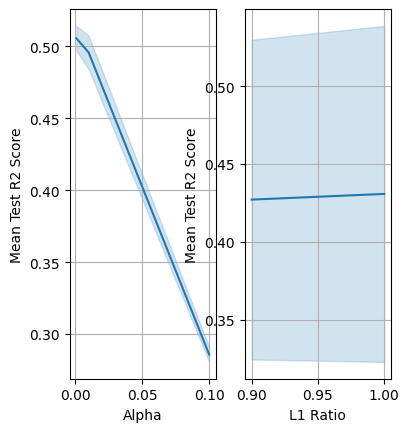

In [ ]:
cv_results_lr = pd.concat(cv_results, ignore_index=True)

plt.subplot(1, 3, 1)
sb.lineplot(data=cv_results_lr, x='param_classifier__alpha', y='mean_test_r2', estimator='mean', ci='sd')
plt.xlabel('Alpha') 
plt.ylabel('Mean Test R2 Score')
plt.grid()

# Plot for L1 Ratio vs Mean Test R2
plt.subplot(1, 3, 2)
sb.lineplot(data=cv_results_lr, x='param_classifier__l1_ratio', y='mean_test_r2', estimator='mean', ci='sd')
plt.xlabel('L1 Ratio') 
plt.ylabel('Mean Test R2 Score')
plt.grid()

In [363]:
print(best_models_lr)

[Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipeline(steps=[('pca',
                 ColumnTransformer(transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('classifier', ElasticNet(alpha=0.001, l1_ratio=1.0))]), Pipelin

# final evaluation
after finding the best number of parameters i will evaluate the best models:

In [414]:
print("random forest regressor with original data: ")
forest_best = RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=110).fit(train_val_features, train_val_targets)
print(evaluate(forest_best, test_features, test_targets))
print()

print("Linear regressor elasticNet with original data: ")
elasticnet_best = ElasticNet(alpha=0.001, l1_ratio=1.0).fit(train_val_features, train_val_targets)
print(evaluate(elasticnet_best, test_features, test_targets))
print()



random forest regressor with original data: 
{'r2': 0.5330863024783817, 'mean_absolute_error': 1.5779874696005323, 'mean_squared_error': 5.1542403021568}

Linear regressor elasticNet with original data: 
{'r2': 0.4852860342205144, 'mean_absolute_error': 1.6749336101279264, 'mean_squared_error': 5.681905415466522}



# Conclusion
random forest regressor is the best model for this dataset. the results are not perfect, they are rather moderately good. i don't know if it is because of the dataset or if i should have done more preprocessing to get better results.

the random forest regressor: 53% of the variance is explained by the model, the model is on average off by 1.577 and the variance between the errors is 5.1. this model is making few but big mistakes, which is not that good in determening age.

# Sourced
https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVR.html SVR  
https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html randomregressor  
https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.ElasticNet.html elasticnet  